### Introduction

In this notebook we will be using SVM model for the **detection of human values** given a specifc argument. It consists of a **Multilabel text classification** problem where a given piece of text needs to be classified into one or more categories out of the given list. For example, as in this case, a given argument can be categorized into 1 or more human values.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Text preprocessing](#section03)
4. [Tf-idf vectorization](#section04)
5. [Building Pipeline](#section05)
6. [Training](#section06)
7. [Evaluation](#section07)
8. [Results](#section08)

#### Technical Details

 - Data: 
	 - We are using the data available on [Zenodo](https://zenodo.org/record/7550385#.Y8wMquzMK3I)
     - [Human Value Detection 2023](https://touche.webis.de/semeval23/touche23-web/index.html) is the competion which provide the souce dataset
	 - We are referring only to the following data: `arguments-training.tsv`, `arguments-validation`, `labels-training.tsv`, `labels-validation.tsv`
	 
     - `arguments-<split>.tsv`: Each row corresponds to one argument
        - `Argument ID`: The unique identifier for the argument
        - `Conclusion`: Conclusion text of the argument
        - `Stance`: Stance of the Premise towards the Conclusion; one of "in favor of", "against"
        - `Premise`: Premise text of the argument

     - `labels-<split>.tsv`: Each row corresponds to one argument
        - `Argument ID`: The unique identifier for the argument
        - `Other`: Each other column corresponds to one value category, with a 1 meaning that the argument resorts to the value category and a 0 that not
---
***NOTE***
- *Since test data are provided without labels, we did not consider them for our analysis. In this regards **the performances of our models have been tested only on validation data**.*
---

 - Script Objective:
	 - Builiding SVM model such that: given a textual argument, classify whether or not the argument draws on one of the following categories:
        * Self-direction: thought      
        * Self-direction: action       
        * Stimulation     
        * Hedonism       
        * Achievement      
        * Power: dominance       
        * Power: resources       
        * Face       
        * Security: personal      
        * Security: societal      
        * Tradition       
        * Conformity: rules       
        * Conformity: interpersonal       
        * Humility       
        * Benevolence: caring       
        * Benevolence: dependability      
        * Universalism: concern       
        * Universalism: nature       
        * Universalism: tolerance      
        * Universalism: objectivity       

---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*
	- *The [accuracy metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [F1 scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) used from sklearn package as compared to direct comparison of expected vs predicted*
---

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Numpy
* Pandas
* Seaborn
* Matplotlib
* Sci-kit learn

RANDOM SEED has been settled to 42 to ensure experiments reproducibility.

In [1]:
!pip install mlcm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from collections import Counter
import math
from mlcm import mlcm
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

import os


In [3]:
# Random seed to repeat experiments.
np.random.seed(42)

<a id='section02'></a>
### Loading data

We will be working with the data and preparing for fine tuning purposes, *assuming that the `arguments-train.tsv`, `labels-train.tsv`, `arguments-validation.tsv`, `labels-validation.tsv` are already downloaded and saved in our `data` folder*

* Import files in different dataframes
* Merge arguments and labels dataframe of each corresponding split 
* Taking the values of all the categories and coverting it into a list.
* Considering only Premises as text input for our classifier

In [4]:
args_train = pd.read_csv("arguments-training.tsv", delimiter='\t')
labels_train = pd.read_csv("labels-training.tsv", delimiter='\t')
args_train.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [5]:
labels_train.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A01006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [6]:
args_test = pd.read_csv("arguments-validation.tsv", delimiter='\t')
labels_test = pd.read_csv("labels-validation.tsv", delimiter='\t')

In [7]:
args_test.head()

,Argument ID,Conclusion,Stance,Premise
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...


In [8]:
print(labels_test.shape)
print(labels_train.shape)

(1896, 21)
(5393, 21)


In [9]:
args_train['Premise']

0       we should ban human cloning as it will only ca...
1       fast food should be banned because it is reall...
2       sometimes economic sanctions are the only thin...
3       capital punishment is sometimes the only optio...
4       factory farming allows for the production of c...
                              ...                        
5388    On the one hand, we have Russia killing countl...
5389    The subsidies were originally intended to ensu...
5390    These products come mainly from large enterpri...
5391    Subsidies often make farmers in recipient coun...
5392    The EU cannot endlessly lean on America or NAT...
Name: Premise, Length: 5393, dtype: object

#SVM

<a id='section03'></a>
# Text Preprocessing with NLTK

In [10]:
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords

# import these modules
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
#REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
PUNTUACTIONS = string.punctuation
BAD_SYMBOLS_RE = re.compile('[^a-z ]')
STOPWORDS = set(stopwords.words('english'))

def preprocess(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    #text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in PUNTUACTIONS) # delete stopwors from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = " ".join(lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text))
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aleba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aleba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aleba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'Conclusion' is not taken into account since it doesn't add any additional information, it is merely a repetition of what have been said in 'premise'. This also prevent overfitting as we are easing the model.

In [11]:
train = args_train.copy()
train['preprocessed'] = args_train['Premise'].apply(lambda text: preprocess(text))

In [12]:
train['preprocessed'][0]

'ban human cloning cause huge issue bunch human running around acting'

In [13]:
test = args_test.copy()
test['preprocessed'] = args_test['Premise'].apply(lambda text: preprocess(text))

In [14]:
train = train.drop(columns= train.columns[1:4])
train

,Argument ID,preprocessed
0,A01002,ban human cloning cause huge issue bunch human...
1,A01005,fast food banned really bad health costly
2,A01006,sometimes economic sanction thing get corrupt ...
3,A01007,capital punishment sometimes option keep crimi...
4,A01008,factory farming allows production cheap food n...
...,...,...
5388,E08016,one hand russia killing countless ukrainian co...
5389,E08017,subsidy originally intended ensure security su...
5390,E08018,product come mainly large enterprise necessari...
5391,E08019,subsidy often make farmer recipient country un...


In [15]:
test = test.drop(columns= test.columns[1:4])
test

,Argument ID,preprocessed
0,A01001,entrapment serve easily capture wanted crimina...
1,A01012,use public defender mandatory people dont mone...
2,A02001,payday loan create impoverished society crazy ...
3,A02002,surrogacy banned woman right choose wish anoth...
4,A02009,entrapment gravely immoral human right coerce ...
...,...,...
1891,E08014,pushing russia wall adverse effect creating ru...
1892,E08021,russian use money give exchange gas spread dis...
1893,E08022,cost gas higher prefer pay little gas bill fin...
1894,E08024,must support country want improve welfare righ...


In [16]:
train = train.merge(labels_train)
train

,Argument ID,preprocessed,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,ban human cloning cause huge issue bunch human...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,fast food banned really bad health costly,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,sometimes economic sanction thing get corrupt ...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,capital punishment sometimes option keep crimi...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,factory farming allows production cheap food n...,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,E08016,one hand russia killing countless ukrainian co...,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5389,E08017,subsidy originally intended ensure security su...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
5390,E08018,product come mainly large enterprise necessari...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5391,E08019,subsidy often make farmer recipient country un...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


In [17]:
test = test.merge(labels_test)
test

,Argument ID,preprocessed,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,entrapment serve easily capture wanted crimina...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,use public defender mandatory people dont mone...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,payday loan create impoverished society crazy ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,surrogacy banned woman right choose wish anoth...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,entrapment gravely immoral human right coerce ...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,E08014,pushing russia wall adverse effect creating ru...,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1892,E08021,russian use money give exchange gas spread dis...,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
1893,E08022,cost gas higher prefer pay little gas bill fin...,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
1894,E08024,must support country want improve welfare righ...,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# TF-IDF VECTORIZATION

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

In [19]:
categories = labels_train.columns[1:]
len(categories)

20

In [20]:
new_train = train.copy().drop(columns=categories)
new_train['categories'] = train[train.columns[2:]].values.tolist()
new_train

,Argument ID,preprocessed,categories
0,A01002,ban human cloning cause huge issue bunch human...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,A01005,fast food banned really bad health costly,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,A01006,sometimes economic sanction thing get corrupt ...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,A01007,capital punishment sometimes option keep crimi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
4,A01008,factory farming allows production cheap food n...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...
5388,E08016,one hand russia killing countless ukrainian co...,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
5389,E08017,subsidy originally intended ensure security su...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
5390,E08018,product come mainly large enterprise necessari...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5391,E08019,subsidy often make farmer recipient country un...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."


In [21]:
new_test = test.copy().drop(columns=categories)
new_test['categories'] = test[test.columns[2:]].values.tolist()
new_test

,Argument ID,preprocessed,categories
0,A01001,entrapment serve easily capture wanted crimina...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,A01012,use public defender mandatory people dont mone...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A02001,payday loan create impoverished society crazy ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,A02002,surrogacy banned woman right choose wish anoth...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,A02009,entrapment gravely immoral human right coerce ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...
1891,E08014,pushing russia wall adverse effect creating ru...,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
1892,E08021,russian use money give exchange gas spread dis...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
1893,E08022,cost gas higher prefer pay little gas bill fin...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1894,E08024,must support country want improve welfare righ...,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."


In [22]:
X_train, Y_train = train.preprocessed, new_train.categories
X_test, Y_test = test.preprocessed, new_test.categories

In [23]:
X_train, Y_train = np.stack(X_train), np.stack(Y_train) 
X_test, Y_test = np.stack(X_test), np.stack(Y_test)

In [24]:
print("X train:", X_train.shape, "\nY train:", Y_train.shape, "\n")
print("X test:", X_test.shape, "\nY test:", Y_test.shape, "\n")

X train: (5393,) 
Y train: (5393, 20) 

X test: (1896,) 
Y test: (1896, 20) 



Definition of useful variables and functions for Error Analysis

In [25]:
test_res = args_test.copy()
test_res = test_res.merge(labels_test)
test_res['preprocessed_premise'] = args_test['Premise'].apply(lambda text: preprocess(text))
test_res['preprocessed_conclusion'] = args_test['Conclusion'].apply(lambda text: preprocess(text))
test_res = test_res.drop(columns= test_res.columns[1:4])
test_res.columns

labels_res = list(labels_test.columns[1:])


TfidfComparison compute a dataframe of size `labels x frequency` that shows the TF-IDF score for each label, considering the most frequent word for a selected label.


In [26]:
def TfidfComparison(dataset, label, labels, frequency=15):

  # selection of the 15 most frequent word for class 'label', conclusion and premises have already been preprocessed
  ds_copy1 = dataset.copy()
  ds_copy1['concat'] = ds_copy1['preprocessed_conclusion'] + ' ' + ds_copy1['preprocessed_premise'] 
  ds_copy1 = list(ds_copy1[ds_copy1[label]==1]['concat'])
  words_freq = Counter([k for k in re.sub('[\W]', ' ', ' '.join(ds_copy1).lower()).split(' ')]) 
  words_freq_dict = {}
  for element, count in words_freq.items():
    words_freq_dict[element]=count

  # sorting the words by frequency and computation of the Document Frequency for each word. The DF is computed class wise due to unbalanced number of data among the classes
  sorted_words_freq_dict = sorted(words_freq_dict.items(), key=lambda x: x[1], reverse=True)[:frequency]
  most_frequent_words = [w for w, v in sorted_words_freq_dict] # stored the most X words for the actual attribute
  df = {}
  for word in most_frequent_words:
    df[word] = 0
    for l in labels:
      ds = dataset.copy()
      ds['concat'] = ds['preprocessed_conclusion'] + ' ' + ds['preprocessed_premise']
      ds = list(ds[ds[l]==1]['concat'])
      label_words = list(set([k for k in re.sub('[\W]', ' ', ' '.join(ds).lower()).split(' ')]))
      if word in label_words:
        df[word] += 1        

    
  
  # computation of TF-IDF for each class among the previously selected 15 words
  tfidf_rows = []
  for l in labels:
    dict_tmp = {}
    if l == label:    
      dict_tmp['ColumnName'] = l
      for word, frequency in sorted_words_freq_dict:
        try:
          dict_tmp[word] = abs(words_freq_dict[word]/sum(list(words_freq_dict.values())) * math.log(len(labels)/df[word],10))
        except: 
          dict_tmp[word] = 0
      tfidf_rows.append(dict_tmp)
      continue
    ds_copy2 = dataset.copy()
    ds_copy2['concat'] = ds_copy2['preprocessed_conclusion'] + ' ' + ds_copy2['preprocessed_premise']
    ds_copy2 = list(ds_copy2[(ds_copy2[label]==0) & (ds_copy2[l]==1)]['concat'])
    words_freq_l = Counter([k for k in re.sub('[\W]', ' ', ' '.join(ds_copy2).lower()).split(' ')])
    words_frequency = {}
    for element, count in words_freq_l.items():
      words_frequency[element]=count
    dict_tmp['ColumnName'] = l
    for word, frequency in sorted_words_freq_dict:
      try:
        dict_tmp[word] = abs(words_frequency[word]/sum(list(words_frequency.values())) * math.log(len(labels)/df[word],10))
      except Exception as ex:
        dict_tmp[word] = 0
    tfidf_rows.append(dict_tmp)
    dataframe = pd.DataFrame(tfidf_rows)
  return dataframe.style.background_gradient(cmap='Reds', subset=dataframe.columns[1:])



# Model Definition and train

In [27]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC

SVC_pipeline = Pipeline([
                ('vector', TfidfVectorizer(max_features=5000)),
                ('svd', TruncatedSVD(n_components=300)),
                ('clf', OneVsRestClassifier(SVC(C=18, kernel='rbf', gamma = 0.01,class_weight='balanced', max_iter=10000, random_state=42), n_jobs=1))
                #('clf', OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, class_weight = 'balanced', random_state=42, max_iter=10000), n_jobs=1)),
            ])

SVC_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('vector', TfidfVectorizer(max_features=5000)),
                ('svd', TruncatedSVD(n_components=300)),
                ('clf',
                 OneVsRestClassifier(estimator=SVC(C=18,
                                                   class_weight='balanced',
                                                   gamma=0.01, max_iter=10000,
                                                   random_state=42),
                                     n_jobs=1))])

# Evaluation


In [28]:
# TRAIN
prediction_train = SVC_pipeline.predict(X_train)
print(classification_report(Y_train, prediction_train, target_names = categories, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.51      0.76      0.61       988
    Self-direction: action       0.58      0.65      0.62      1395
               Stimulation       0.14      0.83      0.24       247
                  Hedonism       0.15      0.92      0.26       172
               Achievement       0.54      0.73      0.62      1512
          Power: dominance       0.28      0.73      0.40       610
          Power: resources       0.45      0.84      0.59       625
                      Face       0.19      0.81      0.31       382
        Security: personal       0.70      0.73      0.71      2000
        Security: societal       0.65      0.76      0.70      1728
                 Tradition       0.39      0.83      0.53       568
         Conformity: rules       0.43      0.68      0.53      1177
 Conformity: interpersonal       0.20      0.90      0.33       207
                  Humility       0.27      0.76

In [29]:
# TEST
prediction = SVC_pipeline.predict(X_test)
print(classification_report(Y_test, prediction, target_names = categories, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.36      0.46      0.40       251
    Self-direction: action       0.50      0.49      0.50       496
               Stimulation       0.12      0.47      0.19       138
                  Hedonism       0.08      0.35      0.13       103
               Achievement       0.47      0.59      0.52       575
          Power: dominance       0.17      0.35      0.23       164
          Power: resources       0.32      0.65      0.42       132
                      Face       0.15      0.61      0.24       130
        Security: personal       0.65      0.64      0.64       759
        Security: societal       0.52      0.55      0.53       488
                 Tradition       0.34      0.33      0.33       172
         Conformity: rules       0.39      0.52      0.44       455
 Conformity: interpersonal       0.07      0.23      0.10        60
                  Humility       0.09      0.19

# Error Analysis

Here, we want to know which classes have been confused with other classes and how frequently. To do this, we are going to use a Multi Label Confusion Matrix, rendered with seaborn's heatmap. For example, we can see that `Universalism: nature` has low values, since the model achieve to distiguish from the others pretty well. (confirmed also in TF-IDF analysis)

MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)


<AxesSubplot:>

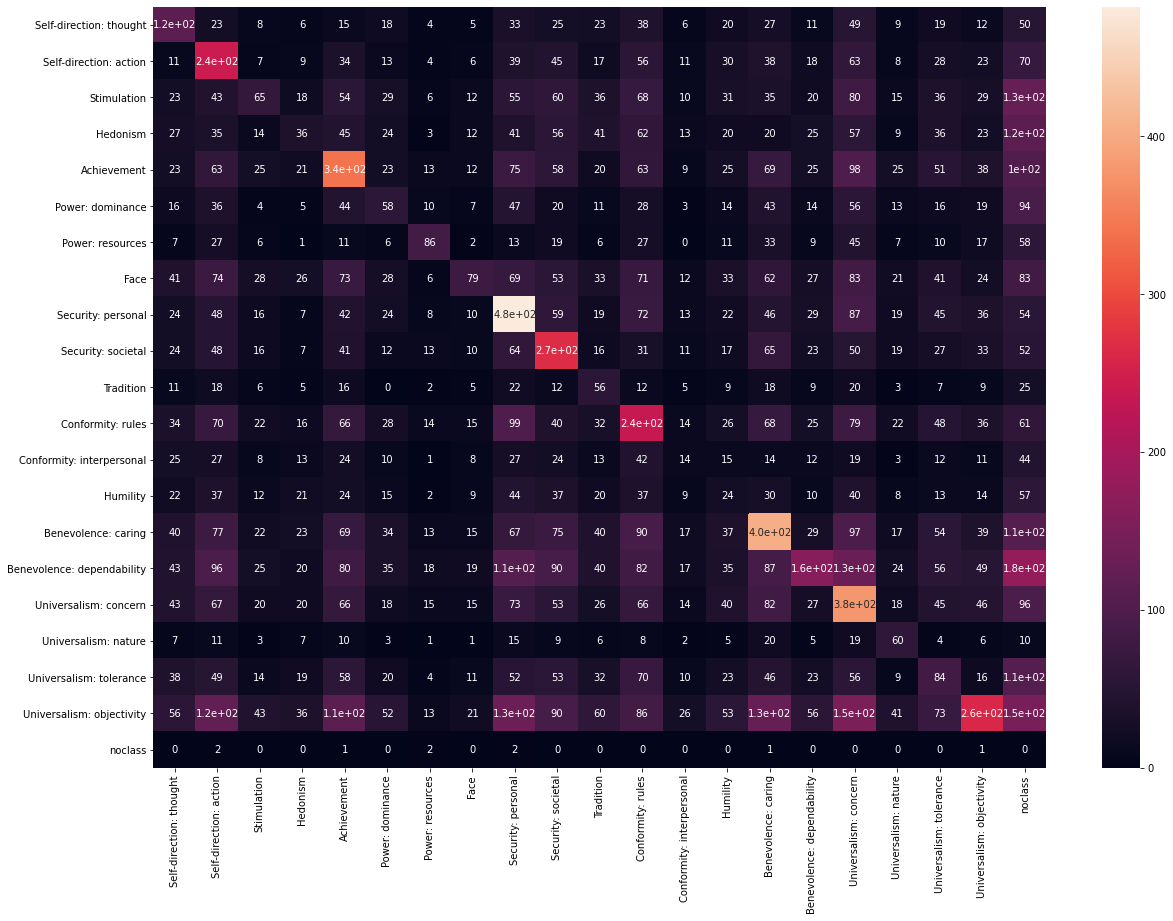

In [30]:
conf_mat,normal_conf_mat = mlcm.cm(prediction,Y_test)
df_cm = pd.DataFrame(conf_mat, index = [i for i in categories.append(pd.Index(['noclass']))],
                  columns = [i for i in categories.append(pd.Index(['noclass']))])
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True)

We retained senseful to analyse the TF-IDF scores that words obtained across all the labels, since SVM is based on this. In general we observed that low support usually coincide with low F1-score, but some anomalies caught our attention.


`Conformity: interpersonal` obtain the lowest F1-score(0.1) and it also has the lowest support(60). The matrix shows perfectly that the most frequent word for this label usually are confused with many other labels(they obtain a good tf-idf score even among other labels)

In [31]:
TfidfComparison(test_res, 'Conformity: interpersonal', labels_res, frequency=15)

,ColumnName,people,holocaust,medium,criminal,social,offence,denial,harm,good,brings,suicide,television,assisted,abandon,bullying
0,Self-direction: thought,0.000000,0.001674,0.000456,0.000000,0.000000,0.000483,0.001447,0.000000,0.000000,0.000000,0.000000,0.000515,0.000091,0.000326,0.000028
1,Self-direction: action,0.000000,0.000548,0.000209,0.000000,0.000000,0.000290,0.000509,0.000000,0.000000,0.000000,0.000000,0.000077,0.000195,0.000052,0.000040
2,Stimulation,0.000000,0.000074,0.000987,0.000000,0.000000,0.000070,0.000074,0.000000,0.000000,0.000000,0.000000,0.000656,0.000059,0.000480,0.000000
3,Hedonism,0.000000,0.000000,0.001054,0.000000,0.000000,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.001159,0.000017,0.000712,0.000000
4,Achievement,0.000000,0.000068,0.000255,0.000000,0.000000,0.000033,0.000068,0.000000,0.000000,0.000000,0.000000,0.000160,0.000017,0.000100,0.000010
5,Power: dominance,0.000000,0.000099,0.000274,0.000000,0.000000,0.000055,0.000124,0.000000,0.000000,0.000000,0.000000,0.000086,0.000024,0.000039,0.000000
6,Power: resources,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000041,0.000000,0.000020,0.000000
7,Face,0.000000,0.000495,0.001146,0.000000,0.000000,0.000112,0.000424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,0.000097
8,Security: personal,0.000000,0.000030,0.000493,0.000000,0.000000,0.000086,0.000024,0.000000,0.000000,0.000000,0.000000,0.000129,0.000099,0.000075,0.000041
9,Security: societal,0.000000,0.000455,0.000209,0.000000,0.000000,0.000203,0.000408,0.000000,0.000000,0.000000,0.000000,0.000054,0.000114,0.000036,0.000026


`Universalism: nature` show low support(127) but it achieve one of the better F1 score(0.46). As can be seen on the matrix, words have a strong TF-IDF score only for `Universalism: nature`, making them good identifiers for this class.

In [32]:
TfidfComparison(test_res, 'Universalism: nature', labels_res, frequency=15)

,ColumnName,natural,energy,nuclear,homeopathy,use,good,harm,people,promote,climate,farming,brings,make,change,animal
0,Self-direction: thought,0.000000,0.000067,0.000000,0.000081,0.000000,0.000000,0.000000,0.000000,0.000043,0.000000,0.000000,0.000000,0.000000,0.000043,0.000014
1,Self-direction: action,0.000042,0.000095,0.000000,0.000121,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000071,0.000013
2,Stimulation,0.000051,0.000000,0.000000,0.000047,0.000000,0.000000,0.000000,0.000000,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hedonism,0.000000,0.000000,0.000000,0.000088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Achievement,0.000011,0.000102,0.000026,0.000120,0.000000,0.000000,0.000000,0.000000,0.000049,0.000018,0.000000,0.000000,0.000000,0.000073,0.000011
5,Power: dominance,0.000000,0.000000,0.000327,0.000107,0.000000,0.000000,0.000000,0.000000,0.000078,0.000000,0.000000,0.000000,0.000000,0.000104,0.000017
6,Power: resources,0.000140,0.000533,0.000533,0.000011,0.000000,0.000000,0.000000,0.000000,0.000237,0.000000,0.000578,0.000000,0.000000,0.000068,0.000022
7,Face,0.000000,0.000000,0.000000,0.000021,0.000000,0.000000,0.000000,0.000000,0.000034,0.000000,0.000000,0.000000,0.000000,0.000034,0.000000
8,Security: personal,0.000051,0.000118,0.000118,0.000215,0.000000,0.000000,0.000000,0.000000,0.000069,0.000000,0.000107,0.000000,0.000000,0.000056,0.000008
9,Security: societal,0.000000,0.000061,0.000273,0.000043,0.000000,0.000000,0.000000,0.000000,0.000039,0.000000,0.000000,0.000000,0.000000,0.000029,0.000006


`Universalism: tolerance` besides having a good support(223) achieves not so good results(0.26). This because its most frequent words are important also for other labels, making them indistinguishable.

In [33]:
TfidfComparison(test_res, 'Universalism: tolerance', labels_res, frequency=15)

,ColumnName,good,people,harm,test,intelligence,criminal,holocaust,offence,social,banned,child,medium,denial,brings,homeschooling
0,Self-direction: thought,0.000000,0.000000,0.000000,0.000240,0.000224,0.000000,0.001495,0.000430,0.000000,0.000000,0.000000,0.000374,0.001285,0.000000,0.000612
1,Self-direction: action,0.000000,0.000000,0.000000,0.000051,0.000043,0.000000,0.000435,0.000246,0.000000,0.000000,0.000000,0.000252,0.000412,0.000000,0.000416
2,Stimulation,0.000000,0.000000,0.000000,0.000031,0.000031,0.000000,0.000048,0.000061,0.000000,0.000000,0.000000,0.001005,0.000048,0.000000,0.000534
3,Hedonism,0.000000,0.000000,0.000000,0.000039,0.000039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001068,0.000000,0.000000,0.000237
4,Achievement,0.000000,0.000000,0.000000,0.000368,0.000332,0.000000,0.000043,0.000027,0.000000,0.000000,0.000000,0.000235,0.000043,0.000000,0.000554
5,Power: dominance,0.000000,0.000000,0.000000,0.000026,0.000018,0.000000,0.000112,0.000062,0.000000,0.000000,0.000000,0.000217,0.000139,0.000000,0.000362
6,Power: resources,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Face,0.000000,0.000000,0.000000,0.000282,0.000231,0.000000,0.000569,0.000128,0.000000,0.000000,0.000000,0.001185,0.000447,0.000000,0.000685
8,Security: personal,0.000000,0.000000,0.000000,0.000073,0.000065,0.000000,0.000040,0.000078,0.000000,0.000000,0.000000,0.000491,0.000033,0.000000,0.000289
9,Security: societal,0.000000,0.000000,0.000000,0.000029,0.000025,0.000000,0.000474,0.000213,0.000000,0.000000,0.000000,0.000203,0.000414,0.000000,0.000072


`Security: personal`: high support and high F1 score. Here we can see that its frequent words are good identifiers since the tf-idf scores are high and different from other classes

In [34]:
TfidfComparison(test_res, 'Security: personal', labels_res, frequency=15)

,ColumnName,good,harm,brings,people,banned,foster,care,loan,social,child,payday,medium,homeopathy,education,vocational
0,Self-direction: thought,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000227,0.000017,0.000111,0.000108
1,Self-direction: action,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000418,0.000000,0.000000,0.000383,0.000154,0.000025,0.000205,0.000508
2,Stimulation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,0.000000,0.000000,0.000000,0.000000,0.000515,0.000000,0.000301,0.000636
3,Hedonism,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000072,0.000000,0.000105,0.000000
4,Achievement,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000049,0.000079,0.000000,0.000000,0.000053,0.000117,0.000038,0.000323,0.000673
5,Power: dominance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000033,0.000000,0.000000,0.000000,0.000000,0.000113,0.000055,0.000044,0.000000
6,Power: resources,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002291,0.000000,0.000000,0.002004,0.000000,0.000000,0.000700,0.002348
7,Face,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,0.000000,0.000465,0.000000,0.000094,0.000239
8,Security: personal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000326,0.002168,0.000000,0.000000,0.001978,0.000524,0.000253,0.000232,0.000618
9,Security: societal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000034,0.000030,0.000000,0.000000,0.000030,0.000174,0.000008,0.000093,0.000283


`Benevolence: dependability`: we can see that `Security: personal` also shares high TF-IDF for frequent words. It can be seen in the multi label confusion matrix that the `Benevolence: dependability` it is usually misclassified as this one.

In [35]:
TfidfComparison(test_res, 'Benevolence: dependability', labels_res, frequency=15)

,ColumnName,good,people,harm,brings,banned,loan,education,social,medium,foster,payday,vocational,care,criminal,subsidize
0,Self-direction: thought,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000128,0.000000,0.000429,0.000000,0.000000,0.000213,0.000000,0.000000,0.000128
1,Self-direction: action,0.000000,0.000000,0.000000,0.000000,0.000000,0.000876,0.000166,0.000000,0.000232,0.000000,0.000876,0.000399,0.000050,0.000000,0.000242
2,Stimulation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000342,0.000000,0.000838,0.000000,0.000000,0.000876,0.000105,0.000000,0.000501
3,Hedonism,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000052,0.000000,0.000779,0.000000,0.000000,0.000000,0.000069,0.000000,0.000000
4,Achievement,0.000000,0.000000,0.000000,0.000000,0.000000,0.000179,0.000414,0.000000,0.000240,0.000000,0.000179,0.000977,0.000094,0.000000,0.000642
5,Power: dominance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000050,0.000000,0.000289,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000
6,Power: resources,0.000000,0.000000,0.000000,0.000000,0.000000,0.004849,0.000526,0.000000,0.000000,0.000000,0.004338,0.001589,0.000037,0.000000,0.001124
7,Face,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000087,0.000000,0.001122,0.000000,0.000000,0.000157,0.000124,0.000000,0.000079
8,Security: personal,0.000000,0.000000,0.000000,0.000000,0.000000,0.001939,0.000216,0.000000,0.000470,0.000000,0.001833,0.000573,0.000309,0.000000,0.000373
9,Security: societal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000194,0.000126,0.000000,0.000208,0.000000,0.000194,0.000387,0.000080,0.000000,0.000255
